# Calculate buoyancy fluxes and plot Figure 5

In [1]:
import numpy as np
import xarray as xr
from glob import glob
import cosima_cookbook as cc
import gsw
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37427/status,
Dashboard: /proxy/37427/status,Workers: 7
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36607,Workers: 7
Dashboard: /proxy/37427/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:43539,Total threads: 4
Dashboard: /proxy/37407/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:39573,


### Define experiment names and session. 

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for ssp585_wind_thermal simulation
session_dir = '/g/data/e14/hd4873/access-om2-01/project03_misc_data/databases/SSP2100_experiments_nodaily.db'
expt_session = cc.database.create_session(session_dir)
ssp585 = '01deg_jra55v13_ryf9091_ssp585'
ssp585mw = '01deg_jra55v13_ryf9091_ssp585_mw'
ssp245 = '01deg_jra55v13_ryf9091_ssp245'
ssp245mw = '01deg_jra55v13_ryf9091_ssp245_mw'

In [4]:
start_time='2160-01-01'
end_time='2164-12-31'
lat_slice  = slice(-85,-59)

st_ocean = cc.querying.getvar(control,'st_ocean',master_session, n=1).load()
geolon_t = cc.querying.getvar(control,'geolon_t',master_session, n=1).sel(yt_ocean=lat_slice).load()
geolat_t = cc.querying.getvar(control,'geolat_t',master_session, n=1).sel(yt_ocean=lat_slice).load()

C_p = 3992.1
g = 9.81
rho0 = 1035

### Create a shelf mask

In [5]:
# load 1000 m isobath mask:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']

# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
# create shelf mask
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)]).sel(yt_ocean=lat_slice)

Read in area variable. This is used to spatially-average diagnostics over the shelf. Note, this must be masked to the shelf before calculating the area sum. 

In [6]:
area_t = cc.querying.getvar(control, 'area_t', master_session,n=1).sel(yt_ocean=lat_slice).load()
temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly', n=1).sel(yt_ocean=lat_slice).isel(time=0).isel(st_ocean=0).load()

# Need to first multiply area_t by an ocean variable to remove grid cell areas that are on land.
area_sum = (area_t*(temp*0+1)*shelf_mask).sum(dim={'xt_ocean','yt_ocean'}).load()
print(area_sum.values)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


2909611200000.0


### Define functions

In [43]:
def thermal_expansion_calc():

    SST = cc.querying.getvar(control, 'surface_temp', master_session, frequency='1 monthly',
                             start_time=start_time, end_time=end_time).sel(time=slice(start_time, 
                                                                                      end_time)).sel(yt_ocean=lat_slice)-273.15
    depth_tile = -(geolat_t*0+1)*st_ocean[0].values
    pressure = xr.DataArray(gsw.p_from_z(depth_tile,geolat_t), 
                            coords=[yt_ocean, xt_ocean], 
                            dims=['yt_ocean', 'xt_ocean'], 
                            name='pressure', 
                            attrs = {'units':'dbar'})
    SSS_PSU = cc.querying.getvar(control, 'surface_salt', master_session, frequency='1 monthly',
                                 start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
   
    # convert units to absolute salinity 
    SSS = xr.DataArray(gsw.SA_from_SP(SSS_PSU, pressure, geolon_t, geolat_t), 
                       coords=[SSS_PSU.time, yt_ocean, xt_ocean], 
                       dims=['time','yt_ocean', 'xt_ocean'], 
                       name='sea surface salinity', 
                       attrs={'units':'Absolute Salinity (g/kg)'})
    thermal_expansion  = xr.DataArray(gsw.alpha(SSS, SST, pressure), 
                                      coords=[SSS_PSU.time, yt_ocean, xt_ocean], 
                                      dims=['time','yt_ocean', 'xt_ocean'], 
                                      name='thermal expansion coefficient ', 
                                      attrs={'units':'1/K'})
    return thermal_expansion


def haline_contraction_calc():

    SST = cc.querying.getvar(control, 'surface_temp', master_session, frequency='1 monthly',
                             start_time=start_time, end_time=end_time).sel(time=slice(start_time, 
                                                                                      end_time)).sel(yt_ocean=lat_slice)-273.15
    depth_tile = -(geolat_t*0+1)*st_ocean[0].values
    pressure = xr.DataArray(gsw.p_from_z(depth_tile,geolat_t), 
                            coords=[yt_ocean, xt_ocean], 
                            dims=['yt_ocean', 'xt_ocean'], 
                            name='pressure', 
                            attrs = {'units':'dbar'})
    SSS_PSU = cc.querying.getvar(control, 'surface_salt', master_session, frequency='1 monthly',
                                 start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
   
    # convert units to absolute salinity 
    SSS = xr.DataArray(gsw.SA_from_SP(SSS_PSU, pressure, geolon_t, geolat_t), 
                       coords=[SSS_PSU.time, yt_ocean, xt_ocean], 
                       dims=['time','yt_ocean', 'xt_ocean'], 
                       name='sea surface salinity', 
                       attrs={'units':'Absolute Salinity (g/kg)'})
    haline_contraction  = xr.DataArray(gsw.beta(SSS, SST, pressure), 
                                       coords=[SSS_PSU.time, yt_ocean, xt_ocean], 
                                       dims=['time','yt_ocean', 'xt_ocean'], 
                                       name='saline contraction coefficient (constant conservative temp)', 
                                       attrs = {'units':'kg/g'})
    return haline_contraction, SSS


def net_heat_buoyancy_flux(expt, session):
    swflx = cc.querying.getvar(expt, 'swflx', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    lw_heat = cc.querying.getvar(expt, 'lw_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    sens_heat = cc.querying.getvar(expt, 'sens_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    evap_heat = cc.querying.getvar(expt, 'evap_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    fprec_melt_heat = cc.querying.getvar(expt, 'fprec_melt_heat', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    sfc_hflux_pme = cc.querying.getvar(expt, 'sfc_hflux_pme', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    sfc_hflux_from_runoff = cc.querying.getvar(expt, 'sfc_hflux_from_runoff', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    frazil_3d_int_z = cc.querying.getvar(expt, 'frazil_3d_int_z', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    
    thermal_expansion = thermal_expansion_calc()   
    net_sfc_heating_ts = (((swflx + lw_heat + sens_heat + evap_heat + 
                            fprec_melt_heat + sfc_hflux_pme + sfc_hflux_from_runoff + 
                            frazil_3d_int_z)*(thermal_expansion/C_p)*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    
    return net_sfc_heating_ts


def net_fw_buoyancy_flux(expt, session):
    lprec = cc.querying.getvar(expt, 'lprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    fprec = cc.querying.getvar(expt, 'fprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    evap = cc.querying.getvar(expt, 'evap', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    river = cc.querying.getvar(expt, 'river', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    wfiform = cc.querying.getvar(expt, 'wfiform', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    wfimelt = cc.querying.getvar(expt, 'wfimelt', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)

    haline_contraction, SSS = haline_contraction_calc()
    net_sfc_fw_flux_ts = ((((lprec + fprec + river + evap + wfiform + wfimelt)*SSS - 
                            (sfc_salt_flux_ice + sfc_salt_flux_restore)*1000)*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    
    return net_sfc_fw_flux_ts


# Total sea ice component of the above fw buoyancy flux
def net_seaice_buoyancy_flux(expt, session):
    sfc_salt_flux_ice = cc.querying.getvar(expt, 'sfc_salt_flux_ice', session, frequency='1 monthly', 
                                           start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    wfiform = cc.querying.getvar(expt, 'wfiform', session, frequency='1 monthly', 
                                 start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    wfimelt = cc.querying.getvar(expt, 'wfimelt', session, frequency='1 monthly', 
                                 start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    haline_contraction, SSS = haline_contraction_calc()
    net_seaice_flux_ts =  ((((wfiform + wfimelt)*SSS - sfc_salt_flux_ice*1000)*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load() 
    return net_seaice_flux_ts

# salt restoring component of the above total fw buoyancy flux 
def net_restore_buoyancy_flux(expt, session):
    sfc_salt_flux_restore = cc.querying.getvar(expt, 'sfc_salt_flux_restore', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    haline_contraction, SSS = haline_contraction_calc()
    net_sfc_restore_flux_ts = - (((sfc_salt_flux_restore)*1000*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    return net_sfc_restore_flux_ts

# runoff component of the total fw buoyancy flux 
def net_river_buoyancy_flux(expt, session):
    river = cc.querying.getvar(expt, 'river', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    haline_contraction, SSS = haline_contraction_calc()
    net_river_flux = ((((river)*SSS)*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    return net_river_flux 

# precipitation component of total fw buoyancy flux 
def net_precip_buoyancy_flux(expt, session):
    lprec = cc.querying.getvar(expt, 'lprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    fprec = cc.querying.getvar(expt, 'fprec', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    haline_contraction, SSS = haline_contraction_calc()
    net_precip_flux = ((((lprec + fprec)*SSS)*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    return net_precip_flux

def net_evap_buoyancy_flux(expt, session):
    evap = cc.querying.getvar(expt, 'evap', session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)
    haline_contraction, SSS = haline_contraction_calc()
    net_evap = ((((evap)*SSS)*haline_contraction*area_t*shelf_mask).sum(dim={'xt_ocean','yt_ocean'})*g/rho0).load()
    return net_evap

### Calculate fluxes

In [46]:
%%time
net_sfc_heat_buoyancy_control = net_heat_buoyancy_flux(control, master_session)
print("SSP245")
net_sfc_heat_buoyancy_ssp245 = net_heat_buoyancy_flux(ssp245, expt_session)
print("SSP245-MW")
net_sfc_heat_buoyancy_ssp245mw = net_heat_buoyancy_flux(ssp245mw, expt_session)
print("SSP585")
net_sfc_heat_buoyancy_ssp585 = net_heat_buoyancy_flux(ssp585, expt_session)
print("SSP585-MW")
net_sfc_heat_buoyancy_ssp585mw = net_heat_buoyancy_flux(ssp585mw, expt_session)

SSP245
SSP245-MW
SSP585
SSP585-MW
CPU times: user 1min 4s, sys: 13.9 s, total: 1min 18s
Wall time: 1min 24s


In [47]:
%%time
net_fw_buoyancy_control = net_fw_buoyancy_flux(control, master_session)
net_fw_buoyancy_ssp245 = net_fw_buoyancy_flux(ssp245, expt_session)
net_fw_buoyancy_ssp245mw = net_fw_buoyancy_flux(ssp245mw, expt_session)
net_fw_buoyancy_ssp585 = net_fw_buoyancy_flux(ssp585, expt_session)
net_fw_buoyancy_ssp585mw = net_fw_buoyancy_flux(ssp585mw, expt_session)

CPU times: user 1min 11s, sys: 14.4 s, total: 1min 26s
Wall time: 1min 30s


In [48]:
%%time
net_restore_buoyancy_control = net_restore_buoyancy_flux(control, master_session)
print("SSP245")
net_restore_buoyancy_ssp245 = net_restore_buoyancy_flux(ssp245, expt_session)
print("SSP245-MW")
net_restore_buoyancy_ssp245mw = net_restore_buoyancy_flux(ssp245mw, expt_session)
print("SSP585")
net_restore_buoyancy_ssp585 = net_restore_buoyancy_flux(ssp585, expt_session)
print("SSP585-MW")
net_restore_buoyancy_ssp585mw = net_restore_buoyancy_flux(ssp585mw, expt_session)

SSP245
SSP245-MW
SSP585
SSP585-MW
CPU times: user 28 s, sys: 6.03 s, total: 34.1 s
Wall time: 34.8 s


In [49]:
%%time
net_seaice_buoyancy_control = net_seaice_buoyancy_flux(control, master_session)
net_seaice_buoyancy_ssp245 = net_seaice_buoyancy_flux(ssp245, expt_session)
net_seaice_buoyancy_ssp245mw = net_seaice_buoyancy_flux(ssp245mw, expt_session)
net_seaice_buoyancy_ssp585 = net_seaice_buoyancy_flux(ssp585, expt_session)
net_seaice_buoyancy_ssp585mw = net_seaice_buoyancy_flux(ssp585mw, expt_session)

CPU times: user 45.4 s, sys: 9.36 s, total: 54.8 s
Wall time: 56 s


In [50]:
%%time
net_river_buoyancy_control = net_river_buoyancy_flux(control, master_session)
net_river_buoyancy_ssp245 = net_river_buoyancy_flux(ssp245, expt_session)
net_river_buoyancy_ssp245mw = net_river_buoyancy_flux(ssp245mw, expt_session)
net_river_buoyancy_ssp585 = net_river_buoyancy_flux(ssp585, expt_session)
net_river_buoyancy_ssp585mw = net_river_buoyancy_flux(ssp585mw, expt_session)

CPU times: user 30.8 s, sys: 6.36 s, total: 37.2 s
Wall time: 38.1 s


In [51]:
%%time
net_precip_buoyancy_control = net_precip_buoyancy_flux(control, master_session)
net_precip_buoyancy_ssp245 = net_precip_buoyancy_flux(ssp245, expt_session)
net_precip_buoyancy_ssp245mw = net_precip_buoyancy_flux(ssp245mw, expt_session)
net_precip_buoyancy_ssp585 = net_precip_buoyancy_flux(ssp585, expt_session)
net_precip_buoyancy_ssp585mw = net_precip_buoyancy_flux(ssp585mw, expt_session)

CPU times: user 36.3 s, sys: 7.4 s, total: 43.7 s
Wall time: 44.1 s


In [52]:
%%time
net_evap_buoyancy_control = net_evap_buoyancy_flux(control, master_session)
net_evap_buoyancy_ssp245 = net_evap_buoyancy_flux(ssp245, expt_session)
net_evap_buoyancy_ssp245mw = net_evap_buoyancy_flux(ssp245mw, expt_session)
net_evap_buoyancy_ssp585 = net_evap_buoyancy_flux(ssp585, expt_session)
net_evap_buoyancy_ssp585mw = net_evap_buoyancy_flux(ssp585mw, expt_session)

CPU times: user 30.2 s, sys: 6.47 s, total: 36.7 s
Wall time: 37.5 s


## Plot figure

In [53]:
def plot_flux(ax, var, label, c, ls, lw):
    ax.plot(var.groupby('time.month').mean(dim='time').month, (var.groupby('time.month').mean('time')*1e-3), 
            color=c,label=label, linestyle=ls, linewidth=lw)
    
def plot_flux_anomaly(ax, var, control, label, c, ls, lw):
    ax.plot(var.groupby('time.month').mean(dim='time').month, 
            ((var.groupby('time.month').mean('time') - control.groupby('time.month').mean('time'))*1e-3), 
             color=c,label=label, linestyle=ls, linewidth=lw)

def figure_setup():

    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,5), sharex=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.1)

    for i, ax in enumerate(axes.flatten()):
        ax.plot([1, 12], [0,0], c='lightgrey')
        ax.set_xlim([1, 12])

    axes[0].set_ylabel('Buoyancy flux (x10$^3$ m$^4$ s$^{-3}$)')
    axes[1].set_ylabel(u'Buoyancy flux anomaly (x10$^3$ m$^4$ s$^{-3}$)', labelpad=0)
    axes[0].set_xlabel('Month')
    axes[1].set_xlabel('Month')
    axes[0].set_xticklabels(['','Feb','Apr','Jun','Aug','Oct','Dec'])
    
    axes[0].text(0.02, 0.91, 'A',  c='k', fontsize=24, fontweight='bold',transform=axes[0].transAxes)
    axes[1].text(0.02, 0.91, 'B',  c='k', fontsize=24, fontweight='bold',transform=axes[1].transAxes)
    
    # axes[0].set_ylim([-42,45])
    # axes[1].set_ylim([-15,30])
    
    return fig, axes

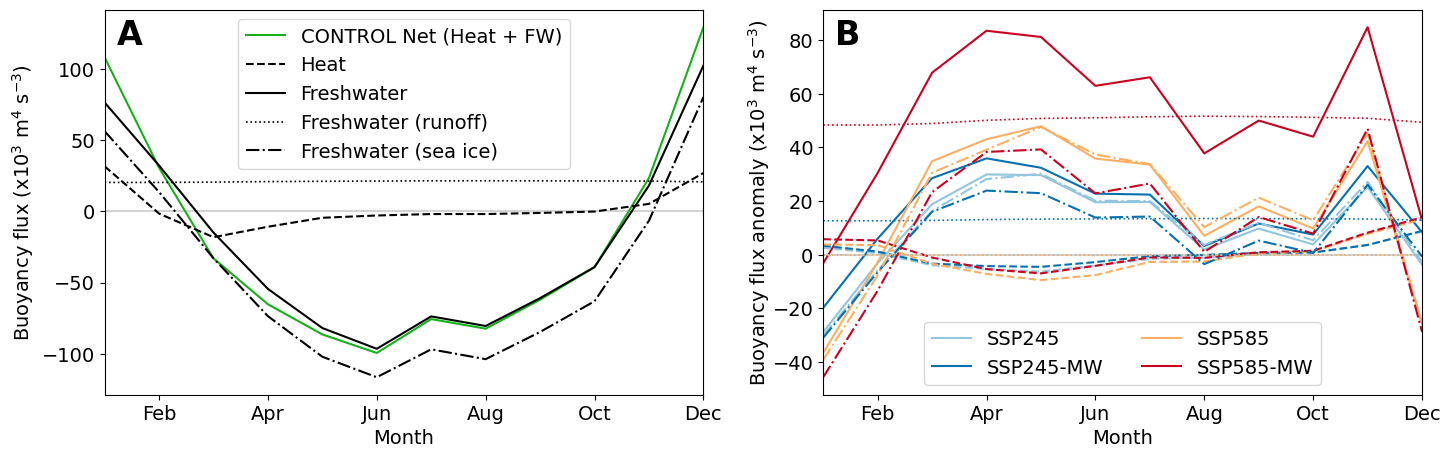

In [54]:
fig, axes = figure_setup()

colours = ['#92c5de', '#0571b0','#fdae61','#ca0020']
lw = 1.5

# Plot control buoyancy fluxes
plot_flux(axes[0], net_sfc_heat_buoyancy_control + net_fw_buoyancy_control, 'CONTROL Net (Heat + FW)', '#15B01A', '-', lw)
plot_flux(axes[0], net_sfc_heat_buoyancy_control, 'Heat', 'k', '--', lw)
plot_flux(axes[0], net_fw_buoyancy_control, 'Freshwater', 'k', '-', lw)
plot_flux(axes[0], net_river_buoyancy_control, 'Freshwater (runoff)', 'k', ':', 1.2)
plot_flux(axes[0], net_seaice_buoyancy_control, 'Freshwater (sea ice)', 'k', '-.', lw)
axes[0].legend()

# Plot buoyancy flux anomalies in the experiments
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp245, net_fw_buoyancy_control, 'SSP245', colours[0], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp245mw, net_fw_buoyancy_control,'SSP245-MW', colours[1], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp585, net_fw_buoyancy_control,'SSP585', colours[2], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp585mw, net_fw_buoyancy_control,'SSP585-MW', colours[3], '-', lw)
axes[1].legend(ncols=2, loc='lower center')

plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp245, net_sfc_heat_buoyancy_control, 'SSP245', colours[0], '--', lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp245mw, net_sfc_heat_buoyancy_control,'SSP245-MW', colours[1], '--',lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp585, net_sfc_heat_buoyancy_control,'SSP585', colours[2], '--', lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp585mw, net_sfc_heat_buoyancy_control,'SSP585-MW', colours[3], '--', lw)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp245, net_river_buoyancy_control, 'SSP245', colours[0], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp245mw, net_river_buoyancy_control,'SSP245 MW', colours[1], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp585, net_river_buoyancy_control,'SSP585', colours[2], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp585mw, net_river_buoyancy_control,'SSP585 MW', colours[3], ':', 1.2)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp245, net_seaice_buoyancy_control, 'SSP245', colours[0], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp245mw, net_seaice_buoyancy_control,'SSP245 MW', colours[1], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp585, net_seaice_buoyancy_control,'SSP585', colours[2], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp585mw, net_seaice_buoyancy_control,'SSP585 MW', colours[3], '-.', lw)

# save to file
save_flag = 1
figfile = f'../Fig05_integrated.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()

This is the figure averaged over the shelf rather than integrated. 

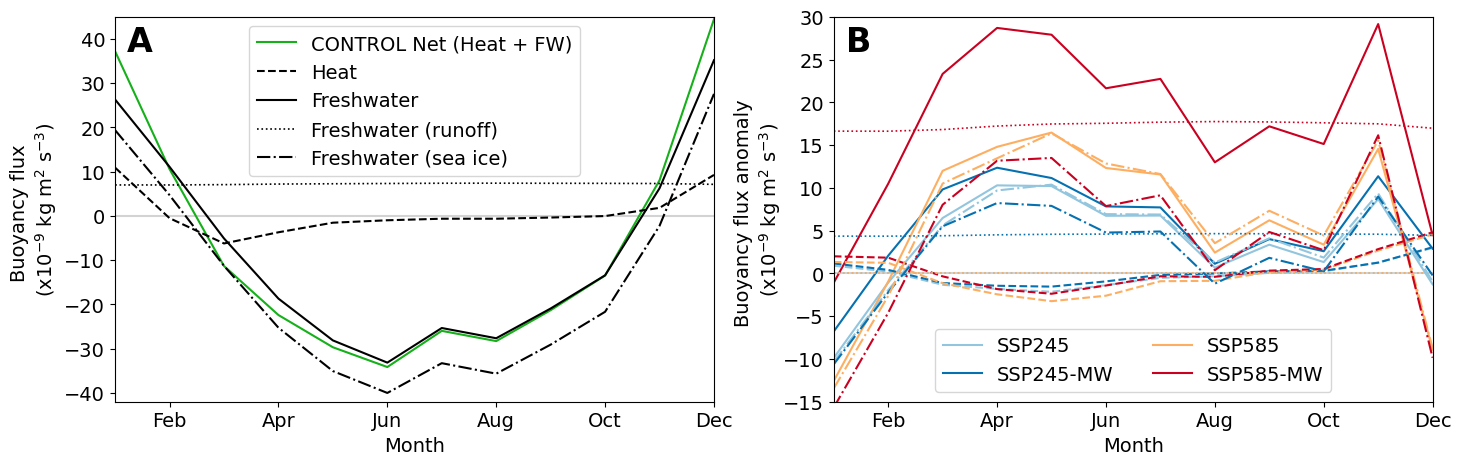

In [18]:
fig, axes = figure_setup()

colours = ['#92c5de', '#0571b0','#fdae61','#ca0020']
lw = 1.5

# Plot control buoyancy fluxes
plot_flux(axes[0], net_sfc_heat_buoyancy_control + net_fw_buoyancy_control, 'CONTROL Net (Heat + FW)', '#15B01A', '-', lw)
plot_flux(axes[0], net_sfc_heat_buoyancy_control, 'Heat', 'k', '--', lw)
plot_flux(axes[0], net_fw_buoyancy_control, 'Freshwater', 'k', '-', lw)
plot_flux(axes[0], net_river_buoyancy_control, 'Freshwater (runoff)', 'k', ':', 1.2)
plot_flux(axes[0], net_seaice_buoyancy_control, 'Freshwater (sea ice)', 'k', '-.', lw)
axes[0].legend()

# Plot buoyancy flux anomalies in the experiments
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp245, net_fw_buoyancy_control, 'SSP245', colours[0], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp245mw, net_fw_buoyancy_control,'SSP245-MW', colours[1], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp585, net_fw_buoyancy_control,'SSP585', colours[2], '-', lw)
plot_flux_anomaly(axes[1], net_fw_buoyancy_ssp585mw, net_fw_buoyancy_control,'SSP585-MW', colours[3], '-', lw)
axes[1].legend(ncols=2, loc='lower center')

plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp245, net_sfc_heat_buoyancy_control, 'SSP245', colours[0], '--', lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp245mw, net_sfc_heat_buoyancy_control,'SSP245-MW', colours[1], '--',lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp585, net_sfc_heat_buoyancy_control,'SSP585', colours[2], '--', lw)
plot_flux_anomaly(axes[1], net_sfc_heat_buoyancy_ssp585mw, net_sfc_heat_buoyancy_control,'SSP585-MW', colours[3], '--', lw)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp245, net_river_buoyancy_control, 'SSP245', colours[0], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp245mw, net_river_buoyancy_control,'SSP245 MW', colours[1], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp585, net_river_buoyancy_control,'SSP585', colours[2], ':', 1.2)
plot_flux_anomaly(axes[1], net_river_buoyancy_ssp585mw, net_river_buoyancy_control,'SSP585 MW', colours[3], ':', 1.2)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp245, net_seaice_buoyancy_control, 'SSP245', colours[0], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp245mw, net_seaice_buoyancy_control,'SSP245 MW', colours[1], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp585, net_seaice_buoyancy_control,'SSP585', colours[2], '-.', lw)
plot_flux_anomaly(axes[1], net_seaice_buoyancy_ssp585mw, net_seaice_buoyancy_control,'SSP585 MW', colours[3], '-.', lw)

# save to file
save_flag = 1
figfile = f'/home/561/hd4873/project3/figs/Fig05_integrated.jpg'
if save_flag == 1:
    fig.savefig(figfile, bbox_inches='tight', dpi=300)

plt.show()